In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data_path = 'data/mnist/'
url_to_file='http://deeplearning.net/data/mnist/mnist.pkl.gz'
filename='mnist.pkl.gz'

# Download data

In [35]:
import requests
import shutil
import os
from tqdm import tqdm

def download_file(data_path=data_path, url_to_file=url_to_file, filename=filename):
    '''Downlaods file from url_to_file to data_path/filename.
    Could add tqdm to show progress'''
    if os.path.isfile(data_path + filename):
        print('{} was already donwloaded!'.format(filename))
    else:
        os.makedirs(data_path, exist_ok=True)
        r = requests.get(url_to_file, stream=True)
        with open(os.path.join(data_path + filename), 'wb') as f:
            shutil.copyfileobj(r.raw, f)
    return filename

In [38]:
test = download_file()

# Load data + preproc

In [3]:
import pickle
import gzip

def depickle(file_path):
    return pickle.load(gzip.open(file_path, 'rb'), encoding='latin-1')

Normalize

In [4]:
((x, y), (x_valid, y_valid), _) = depickle(data_path+filename)

In [5]:
mean = x.mean()
std = x.std()

In [6]:
x = (x-mean)/std
mean, x.mean(), std, x.std()

(0.13044983, -3.1638146e-07, 0.3072898, 0.99999934)

In [7]:
x_valid = (x_valid-mean)/std
x_valid.mean(), x_valid.std()

(-0.005850922, 0.99243325)

# Inspect data

In [124]:
def showim(img, label, index):
    x = np.reshape(img[index,:],(-1, 28,28))
    plt.title('label = '+str(label[index]), fontsize=19)
    plt.imshow(x[0,:,:])

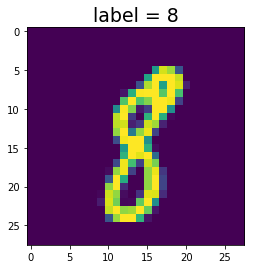

In [125]:
showim(x,y,300)

# Implementation

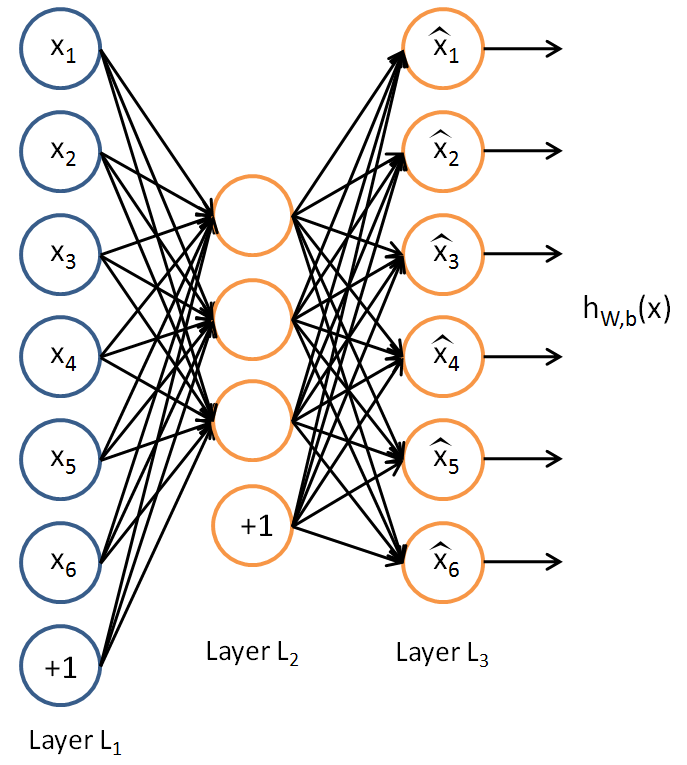

In [44]:
from IPython.display import Image
Image("Autoencoder636.png")

## Simple autoencoder

In [8]:
def relu(x):
    x[x < 0] = 0
    return x
    
def relu_d(x):
     x[x<=0] = 0
     x[x>0] = 1
     return x
    
def softmax(x):
    '''stable way of computing softmax'''
    shiftx = x - np.expand_dims(np.max(x, axis=1),1)
    exps = np.exp(shiftx)
    return exps / np.expand_dims(np.sum(exps, axis=1), 1)    

def sigmoid(x):
    shiftx = x - np.expand_dims(np.max(x, axis=1),1)
    return 1 / (1 + np.exp(-shiftx))
#     return 1 / (1 + np.exp(-x))

def sigmoid_d(x):
    return x * (1-x)
#     return sigmoid(x) * (1-sigmoid(x))

def onehot(y):
    size = len(y)
    one = np.zeros((size, 10))
    one[np.arange(size),y] = 1
    return one

def onehot_d(x):
    return np.argmax(x)
    
def generator(bs, examples, labels):
    n_batches = int(np.floor(len(examples)/bs))
    it = 0
    while it <= n_batches*bs-1:
        yield examples[it:it+bs,:], labels[it:it+bs], n_batches
        it += bs
    it = 0
    
# def generator(bs, examples, labels):
#     n_batches = int(np.floor(len(examples)/bs))
#     ids = np.random.permutation(len(examples))
#     it = 0
#     while it <= n_batches*bs-1:
#         yield examples[ids[it:it+bs],:], labels[ids[it:it+bs]], n_batches
#         it += bs
#     it = 0
#     ids = np.random.permutation(len(examples))

In [9]:
bs = 32
imdim = 28
outer_layer = imdim**2
hidden_layer = 100
losstot1 = []
losstot2 = []

In [10]:
W1 = np.random.rand(outer_layer, hidden_layer)*2-1
W2 = np.random.rand(hidden_layer, outer_layer)*2-1
spar = np.zeros((hidden_layer))

In [11]:
W1 = np.random.rand(outer_layer, hidden_layer)*2-1
W2 = np.random.rand(hidden_layer, outer_layer)*2-1
spar = np.zeros((hidden_layer))+0.01

epochs = 15
eta = 0.1
spar_hp = 0.05
beta = 0.1

for i in range(epochs):
    cost1, cost2, j = 0., 0., 0
    spar_new = np.zeros_like(spar)+0.01
    for a1, labs, n_batches in generator(bs, x, y):
        # forward pass
        z2 = np.dot(a1, W1)
        a2 = sigmoid(z2)
        a3 = np.dot(a2, W2)
        
        # cost
        cost1 += np.sum(0.5 * np.abs(a3-a1)**2)
        spar_int = spar
        cost2 += np.sum(spar_hp*np.log(spar_hp/spar_int)+(1-spar_hp)*np.log((1-spar_hp)/(1-spar_int)))
        j += 1
        spar_new += a2.mean(axis=0)
        
        # backward pass
        d3 = a3 - a1
        d2_se = np.dot(d3, W2.T)
        d2_kl = beta*((1-spar_hp)/(1-spar[0])-(spar_hp)/(spar[0]))
        d2 = (d2_se + d2_kl) * sigmoid_d(a2)
        
#         print('deel 1 = ', (1-spar_hp)/(1-spar[0]))
#         print('deel 2 = ', (spar_hp)/(spar[0]))
#         print('W1 = ', W1)
#         print('W2 = ', W2)
        # update weights
        W2 -= eta * np.dot(a2.T,d3) / bs
        W1 -= eta * np.dot(a1.T,d2) / bs
        
        # batch normalization
        temp = (W1.std(), W1.mean())
        W1 = (W1 / temp[0])-temp[1]
        temp = (W2.std(), W2.mean())
        W2 = (W2 / temp[0])-temp[1]
        
    spar = spar_new / n_batches
    
    if i%(1) == 0:
        print('epoch             = ', i)
        print('loss1   = {}'.format(cost1/j*bs))
        print('loss2   = {}'.format(cost2/j*bs))
        for a1_v, labs_v, n_batches in generator(bs, x_valid, y_valid):
            z2_v = np.dot(a1_v, W1)
            a2_v = sigmoid(z2_v)
            a3 = np.dot(a2_v, W2)
#         print('valid   = ', trues/(n_batches*bs)*100, '%')
    
print('Done!')

/home/stijn/miniconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in exp


epoch             =  0
loss1   = 455429.34011126915
loss2   = 132.13147204594284
epoch             =  1
loss1   = 316208.3351487192
loss2   = 204.43461928099882
epoch             =  2
loss1   = 298517.179032879
loss2   = 453.2606112465627
epoch             =  3
loss1   = 292808.2920289313
loss2   = 542.8055743512506
epoch             =  4
loss1   = 289765.7459438559
loss2   = 552.7279132613564
epoch             =  5
loss1   = 289534.5279345699
loss2   = 544.2638917112132
epoch             =  6
loss1   = 289706.7191143515
loss2   = 531.7151840694713
epoch             =  7
loss1   = 289789.4810443541
loss2   = 525.5289695848775
epoch             =  8
loss1   = 289757.33984954923
loss2   = 522.3464489168161
epoch             =  9
loss1   = 289576.84332960227
loss2   = 521.372274851629
epoch             =  10
loss1   = 289541.60197354737
loss2   = 524.9938608113159
epoch             =  11
loss1   = 289119.2066097608
loss2   = 524.7581720384416
epoch             =  12
loss1   = 289064.83912

epoch             =  0
loss1   = 0.0
loss2   = 0.0
epoch             =  1
loss1   = 0.0
loss2   = 0.0
epoch             =  2
loss1   = 0.0
loss2   = 0.0
epoch             =  3
loss1   = 0.0
loss2   = 0.0
epoch             =  4
loss1   = 0.0
loss2   = 0.0
epoch             =  5
loss1   = 0.0
loss2   = 0.0
epoch             =  6
loss1   = 0.0
loss2   = 0.0
epoch             =  7
loss1   = 0.0
loss2   = 0.0
epoch             =  8
loss1   = 0.0
loss2   = 0.0
epoch             =  9
loss1   = 0.0
loss2   = 0.0
epoch             =  10
loss1   = 0.0
loss2   = 0.0
epoch             =  11
loss1   = 0.0
loss2   = 0.0
epoch             =  12
loss1   = 0.0
loss2   = 0.0
epoch             =  13
loss1   = 0.0
loss2   = 0.0
epoch             =  14
loss1   = 0.0
loss2   = 0.0
Done!


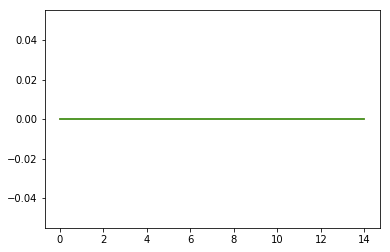

In [17]:
losstot1 = []
losstot2 = []
W1 = np.random.rand(outer_layer, hidden_layer)*2-1
W2 = np.random.rand(hidden_layer, outer_layer)*2-1
spar = np.zeros((hidden_layer))+0.01

epochs = 15
eta = 0.1
spar_hp = 0.05
beta = 0.1

for i in range(epochs):
    cost1, cost2, j = 0., 0., 1
    spar_new = np.zeros_like(spar)
    for a1, labs, n_batches in generator(bs, x, y):
        # forward pass
        z2 = np.dot(a1, W1)
        a2 = sigmoid(z2)
        a3 = np.dot(a2, W2)
        
        # cost
        cost1 += np.sum(0.5 * np.abs(a3-a1)**2)
        spar_int = spar
        cost2 += np.sum(spar_hp*np.log(spar_hp/spar_int)+(1-spar_hp)*np.log((1-spar_hp)/(1-spar_int)))
        spar_new += a2.mean(axis=0)
        
        # backward pass
        d3 = a3 - a1
        d2_se = np.dot(d3, W2.T)
        d2_kl = beta*((1-spar_hp)/(1-spar[0])-(spar_hp)/(spar[0]))
        d2 = (d2_se + d2_kl) * sigmoid_d(a2)
        
#         print('deel 1 = ', (1-spar_hp)/(1-spar[0]))
#         print('deel 2 = ', (spar_hp)/(spar[0]))
#         print('W1 = ', W1)
#         print('W2 = ', W2)
        # update weights
        W2 -= eta * np.dot(a2.T,d3) / bs
        W1 -= eta * np.dot(a1.T,d2) / bs
        
        # batch normalization
#         temp = (W1.std(), W1.mean())
#         W1 = (W1 / temp[0])-temp[1]
#         temp = (W2.std(), W2.mean())
#         W2 = (W2 / temp[0])-temp[1]
        
    spar = spar_new / n_batches
    if i%(1) == 0:
        print('epoch             = ', i)
        print('loss1   = {}'.format(cost1/(j*bs)))
        print('loss2   = {}'.format(cost2/(j*bs)))
#         for a1_v, labs_v, n_batches in generator(bs, x_valid, y_valid):
#             z2_v = np.dot(a1_v, W1)
#             a2_v = sigmoid(z2_v)
#             a3 = np.dot(a2_v, W2)
#         print('valid   = ', trues/(n_batches*bs)*100, '%')
    losstot1.append(cost1/(j*bs))
    losstot2.append(cost2/(j*bs))
    j += 1
    
x = np.arange(epochs)
plt.plot(x, losstot1)
plt.plot(x, losstot2)
plt.plot(x, [sum(x) for x in zip(losstot1, losstot2)])

print('Done!')

In [229]:
losstot2

[0.0, 0.0]

NOTES:  
d2_kl explodeerde omdat spar initialized was op 0. nu bij initializatie op iets anders gezet

In [ ]:
print(W1)
a = np.array([1,2])
2-a

In [16]:
i=0

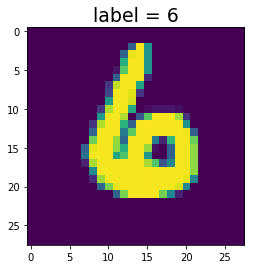

In [431]:
showim(a1, labs, i)
i+=1

## Plus batchnorm, shuffled generator

In [92]:
def entropy_spread(x): #breuklijn, 1/x is de kans op het klein deel
    p1 = 1/x
    p2 = 1 - 1/x
    return p1*np.log2(p1)+p2*np.log2(p2)

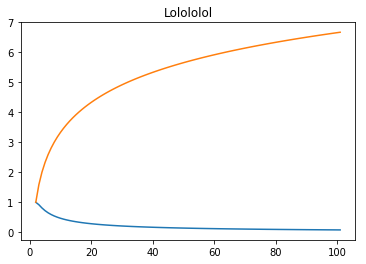

In [107]:
x = np.arange(100)+2
plt.title('Lolololol')

plt.plot(x, -entropy_spread(x))
plt.plot(x, -np.log2(1/x))


# x = np.reshape(img[index,:],(-1, 28,28))
# plt.imshow(x[0,:,:])

## Links

http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/  
https://www.youtube.com/watch?v=ErfnhcEV1O8  
https://timvieira.github.io/blog/post/2014/10/06/kl-divergence-as-an-objective-function/  
